In [ ]:
#default_exp torch_core

In [ ]:
#export
from local.test import *
from local.basics import *
from local.torch_imports import *
from local.notebook.showdoc import *
from fastprogress import progress_bar,master_bar

In [ ]:
#export
_all_ = ['progress_bar','master_bar']

In [ ]:
#export
if torch.cuda.is_available(): torch.cuda.set_device(int(os.environ.get('DEFAULT_GPU') or 0))

# Torch Core

> Basic pytorch functions used in the fastai library

## Basics

In [ ]:
#export
@patch
def __array_eq__(self:Tensor,b):
    return torch.equal(self,b) if self.dim() else self==b

In [ ]:
#export
def tensor(x, *rest, **kwargs):
    "Like `torch.as_tensor`, but handle lists too, and can pass multiple vector elements directly."
    if len(rest): x = (x,)+rest
    # Pytorch bug in dataloader using num_workers>0
    if isinstance(x, (tuple,list)) and len(x)==0: return tensor(0)
    res = (torch.tensor(x, **kwargs) if isinstance(x, (tuple,list))
           else as_tensor(x.values, **kwargs) if isinstance(x, (pd.Series, pd.DataFrame))
           else as_tensor(x, **kwargs) if hasattr(x, '__array__') or is_iter(x)
           else None)
    if res is None:
        res = as_tensor(array(x), **kwargs)
        if res.dtype is torch.float64: return res.float()
    if res.dtype is torch.int32:
        warn('Tensor is int32: upgrading to int64; for better performance use int64 input')
        return res.long()
    return res

In [ ]:
test_eq(tensor(array([1,2,3])), torch.tensor([1,2,3]))
test_eq(tensor(1,2,3), torch.tensor([1,2,3]))
test_eq_type(tensor(1.0), torch.tensor(1.0))

In [ ]:
#export
def set_seed(s):
    "Set random seed for `random`, `torch`, and `numpy` (where available)"
    try: torch.manual_seed(s)
    except NameError: pass
    try: np.random.seed(s%(2**32-1))
    except NameError: pass
    random.seed(s)

In [ ]:
set_seed(2*33)
a1 = np.random.random()
a2 = torch.rand(())
a3 = random.random()
set_seed(2*33)
b1 = np.random.random()
b2 = torch.rand(())
b3 = random.random()
test_eq(a1,b1)
test_eq(a2,b2)
test_eq(a3,b3)

In [ ]:
#export
def _fa_rebuild_tensor (cls, *args, **kwargs): return cls(torch._utils._rebuild_tensor_v2(*args, **kwargs))
def _fa_rebuild_qtensor(cls, *args, **kwargs): return cls(torch._utils._rebuild_qtensor  (*args, **kwargs))

In [ ]:
#export
class TensorBase(Tensor, metaclass=BypassNewMeta):
    def _new_meta(self, *args, **kwargs): return tensor(self)

    def __reduce_ex__(self,proto):
        torch.utils.hooks.warn_if_has_hooks(self)
        args = (type(self), self.storage(), self.storage_offset(), tuple(self.size()), self.stride())
        if self.is_quantized: args = args + (self.q_scale(), self.q_zero_point())
        f = _fa_rebuild_qtensor if self.is_quantized else  _fa_rebuild_tensor
        return (f, args + (self.requires_grad, OrderedDict()))

In [ ]:
#export
def _patch_tb():
    def get_f(fn):
        def _f(self, *args, **kwargs):
            cls = self.__class__
            res = getattr(super(TensorBase, self), fn)(*args, **kwargs)
            return cls(res) if isinstance(res,Tensor) else res
        return _f

    t = tensor([1])
    skips = '__class__ __deepcopy__ __delattr__ __dir__ __doc__ __getattribute__ __hash__ __init__ \
        __init_subclass__ __new__ __reduce__ __reduce_ex__ __module__ __setstate__'.split()

    for fn in dir(t):
        if fn in skips: continue
        f = getattr(t, fn)
        if isinstance(f, (MethodWrapperType, BuiltinFunctionType, BuiltinMethodType, MethodType, FunctionType)):
            setattr(TensorBase, fn, get_f(fn))

_patch_tb()

In [ ]:
class _T(TensorBase): pass

t = _T(range(5))
test_eq_type(t[0], _T(0))
test_eq_type(t[:2], _T([0,1]))
test_eq_type(t+1, _T(range(1,6)))

test_eq(type(pickle.loads(pickle.dumps(t))), _T)

## L -

In [ ]:
#export
@patch
def tensored(self:L):
    "`mapped(tensor)`"
    return self.map(tensor)
@patch
def stack(self:L, dim=0):
    "Same as `torch.stack`"
    return torch.stack(list(self.tensored()), dim=dim)
@patch
def cat  (self:L, dim=0):
    "Same as `torch.cat`"
    return torch.cat  (list(self.tensored()), dim=dim)

In [ ]:
show_doc(L.tensored)

<h4 id="L.tensored" class="doc_header"><code>L.tensored</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L2" class="source_link" style="float:right">[source]</a></h4>

> <code>L.tensored</code>()

`mapped(tensor)`

There are shortcuts for `torch.stack` and `torch.cat` if your `L` contains tensors or something convertible. You can manually convert with `tensored`.

In [ ]:
t = L(([1,2],[3,4]))
test_eq(t.tensored(), [tensor(1,2),tensor(3,4)])

In [ ]:
show_doc(L.stack)

<h4 id="L.stack" class="doc_header"><code>L.stack</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L6" class="source_link" style="float:right">[source]</a></h4>

> <code>L.stack</code>(**`dim`**=*`0`*)

Same as `torch.stack`

In [ ]:
test_eq(t.stack(), tensor([[1,2],[3,4]]))

In [ ]:
show_doc(L.cat)

<h4 id="L.cat" class="doc_header"><code>L.cat</code><a href="https://github.com/fastai/fastai_dev/tree/master/dev/__main__.py#L10" class="source_link" style="float:right">[source]</a></h4>

> <code>L.cat</code>(**`dim`**=*`0`*)

Same as `torch.cat`

In [ ]:
test_eq(t.cat(), tensor([1,2,3,4]))

## Chunks

In [ ]:
#export
def concat(*ls):
    "Concatenate tensors, arrays, lists, or tuples"
    if not len(ls): return []
    it = ls[0]
    if isinstance(it,torch.Tensor): res = torch.cat(ls)
    elif isinstance(it,ndarray): res = np.concatenate(ls)
    else:
        res = itertools.chain.from_iterable(map(L,ls))
        if isinstance(it,(tuple,list)): res = type(it)(res)
        else: res = L(res)
    return retain_type(res, it)

In [ ]:
a,b,c = [1],[1,2],[1,1,2]
test_eq(concat(a,b), c)
test_eq_type(concat(tuple (a),tuple (b)), tuple (c))
test_eq_type(concat(array (a),array (b)), array (c))
test_eq_type(concat(tensor(a),tensor(b)), tensor(c))
test_eq_type(concat(TensorBase(a),TensorBase(b)), TensorBase(c))
test_eq_type(concat([1,1],1), [1,1,1])
test_eq_type(concat(1,1,1), L(1,1,1))
test_eq_type(concat(L(1,2),1), L(1,2,1))

In [ ]:
#export
class Chunks:
    "Slice and int indexing into a list of lists"
    def __init__(self, chunks, lens=None):
        self.chunks = chunks
        self.lens = L(map(len,self.chunks) if lens is None else lens)
        self.cumlens = np.cumsum(0+self.lens)
        self.totlen = self.cumlens[-1]

    def __getitem__(self,i):
        if isinstance(i,slice): return self.getslice(i)
        di,idx = self.doc_idx(i)
        return self.chunks[di][idx]

    def getslice(self, i):
        st_d,st_i = self.doc_idx(ifnone(i.start,0))
        en_d,en_i = self.doc_idx(ifnone(i.stop,self.totlen+1))
        res = [self.chunks[st_d][st_i:(en_i if st_d==en_d else sys.maxsize)]]
        for b in range(st_d+1,en_d): res.append(self.chunks[b])
        if st_d!=en_d and en_d<len(self.chunks): res.append(self.chunks[en_d][:en_i])
        return concat(*res)

    def doc_idx(self, i):
        if i<0: i=self.totlen+i # count from end
        docidx = np.searchsorted(self.cumlens, i+1)-1
        cl = self.cumlens[docidx]
        return docidx,i-cl

In [ ]:
docs = L(list(string.ascii_lowercase[a:b]) for a,b in ((0,3),(3,7),(7,8),(8,16),(16,24),(24,26)))

b = Chunks(docs)
test_eq([b[ o] for o in range(0,5)], ['a','b','c','d','e'])
test_eq([b[-o] for o in range(1,6)], ['z','y','x','w','v'])
test_eq(b[6:13], 'g,h,i,j,k,l,m'.split(','))
test_eq(b[20:77], 'u,v,w,x,y,z'.split(','))
test_eq(b[:5], 'a,b,c,d,e'.split(','))
test_eq(b[:2], 'a,b'.split(','))

In [ ]:
t = torch.arange(26)
docs = L(t[a:b] for a,b in ((0,3),(3,7),(7,8),(8,16),(16,24),(24,26)))
b = Chunks(docs)
test_eq([b[ o] for o in range(0,5)], range(0,5))
test_eq([b[-o] for o in range(1,6)], [25,24,23,22,21])
test_eq(b[6:13], torch.arange(6,13))
test_eq(b[20:77], torch.arange(20,26))
test_eq(b[:5], torch.arange(5))
test_eq(b[:2], torch.arange(2))

In [ ]:
docs = L(TensorBase(t[a:b]) for a,b in ((0,3),(3,7),(7,8),(8,16),(16,24),(24,26)))
b = Chunks(docs)
test_eq_type(b[:2], TensorBase(range(2)))
test_eq_type(b[:5], TensorBase(range(5)))
test_eq_type(b[9:13], TensorBase(range(9,13)))

## Other functions

In [ ]:
#export
def one_param(m):
    "First parameter in `m`"
    return next(iter(m.parameters()))

In [ ]:
#export
def apply(func, x, *args, **kwargs):
    "Apply `func` recursively to `x`, passing on args"
    if is_listy(x): return type(x)([apply(func, o, *args, **kwargs) for o in x])
    if isinstance(x,dict):  return {k: apply(func, v, *args, **kwargs) for k,v in x.items()}
    res = func(x, *args, **kwargs)
    return res if x is None else retain_type(res, x)

In [ ]:
#export
def to_detach(b, cpu=True):
    "Recursively detach lists of tensors in `b `; put them on the CPU if `cpu=True`."
    def _inner(x, cpu=True):
        if not isinstance(x,Tensor): return x
        x = x.detach()
        return x.cpu() if cpu else x
    return apply(_inner, b, cpu=cpu)

In [ ]:
#export
def to_half(b):
    "Recursively map lists of tensors in `b ` to FP16."
    return apply(lambda x: x.half() if torch.is_floating_point(x) else x, b)

In [ ]:
#export
def to_float(b):
    "Recursively map lists of int tensors in `b ` to float."
    return apply(lambda x: x.float() if torch.is_floating_point(x) else x, b)

In [ ]:
#export
# None: True if available; True: error if not availabe; False: use CPU
defaults.use_cuda = None

In [ ]:
#export
def default_device(use_cuda=-1):
    "Return or set default device; `use_cuda`: None - CUDA if available; True - error if not availabe; False - CPU"
    if use_cuda != -1: defaults.use_cuda=use_cuda
    use = defaults.use_cuda or (torch.cuda.is_available() and defaults.use_cuda is None)
    assert torch.cuda.is_available() or not use
    return torch.device(torch.cuda.current_device()) if use else torch.device('cpu')

In [ ]:
#cuda
_td = torch.device(torch.cuda.current_device())
test_eq(default_device(None), _td)
test_eq(default_device(True), _td)
test_eq(default_device(False), torch.device('cpu'))
default_device(None);

In [ ]:
#export
def to_device(b, device=None):
    "Recursively put `b` on `device`."
    if device is None: device=default_device()
    def _inner(o): return o.to(device, non_blocking=True) if isinstance(o,Tensor) else o
    return apply(_inner, b)

In [ ]:
t = to_device((3,(tensor(3),tensor(2))))
t1,(t2,t3) = t
test_eq_type(t,(3,(tensor(3).cuda(),tensor(2).cuda())))
test_eq(t2.type(), "torch.cuda.LongTensor")
test_eq(t3.type(), "torch.cuda.LongTensor")

In [ ]:
#export
def to_cpu(b):
    "Recursively map lists of tensors in `b ` to the cpu."
    return to_device(b,'cpu')

In [ ]:
t3 = to_cpu(t3)
test_eq(t3.type(), "torch.LongTensor")
test_eq(t3, 2)

In [ ]:
# #export
# def to_np(x):
#     "Convert a tensor to a numpy array."
#     return apply(Self.detach().cpu().numpy(), x)

In [ ]:
#export
def to_np(x):
    "Convert a tensor to a numpy array."
    return apply(lambda o: o.data.cpu().numpy(), x)

In [ ]:
t3 = to_np(t3)
test_eq(type(t3), np.ndarray)
test_eq(t3, 2)

In [ ]:
#export
def item_find(x, idx=0):
    "Recursively takes the `idx`-th element of `x`"
    if is_listy(x): return item_find(x[idx])
    if isinstance(x,dict):
        key = list(x.keys())[idx] if isinstance(idx, int) else idx
        return item_find(x[key])
    return x

In [ ]:
#export
def find_device(b):
    "Recursively search the device of `b`."
    return item_find(b).device

In [ ]:
dev = default_device()
test_eq(find_device(t2), dev)
test_eq(find_device([t2,t2]), dev)
test_eq(find_device({'a':t2,'b':t2}), dev)
test_eq(find_device({'a':[[t2],[t2]],'b':t2}), dev)

In [ ]:
#export
def find_bs(b):
    "Recursively search the batch size of `b`."
    return item_find(b).shape[0]

In [ ]:
x = torch.randn(4,5)
test_eq(find_bs(x), 4)
test_eq(find_bs([x, x]), 4)
test_eq(find_bs({'a':x,'b':x}), 4)
test_eq(find_bs({'a':[[x],[x]],'b':x}), 4)

In [ ]:
def np_func(f):
    "Convert a function taking and returning numpy arrays to one taking and returning tensors"
    def _inner(*args, **kwargs):
        nargs = [to_np(arg) if isinstance(arg,Tensor) else arg for arg in args]
        return tensor(f(*nargs, **kwargs))
    functools.update_wrapper(_inner, f)
    return _inner

This decorator is particularly useful for using numpy functions as fastai metrics, for instance:

In [ ]:
from sklearn.metrics import f1_score

@np_func
def f1(inp,targ): return f1_score(targ, inp)

a1,a2 = array([0,1,1]),array([1,0,1])
t = f1(tensor(a1),tensor(a2))
test_eq(f1_score(a1,a2), t)
assert isinstance(t,Tensor)

In [ ]:
#export
class Module(nn.Module, metaclass=PrePostInitMeta):
    "Same as `nn.Module`, but no need for subclasses to call `super().__init__`"
    def __pre_init__(self, *args, **kwargs): super().__init__()
    def __init__(self): pass

In [ ]:
show_doc(Module, title_level=3)

<h3 id="Module" class="doc_header"><code>class</code> <code>Module</code><a href="" class="source_link" style="float:right">[source]</a></h3>

> <code>Module</code>() :: [`Module`](/torch.core.html#Module)

Same as `nn.Module`, but no need for subclasses to call `super().__init__`

In [ ]:
class _T(Module):
    def __init__(self): self.f = nn.Linear(1,1)
    def forward(self,x): return self.f(x)

t = _T()
t(tensor([1.]))

tensor([-1.0893], grad_fn=<AddBackward0>)

In [ ]:
# export
from torch.nn.parallel import DistributedDataParallel

def get_model(model):
    "Return the model maybe wrapped inside `model`."
    return model.module if isinstance(model, (DistributedDataParallel, nn.DataParallel)) else model

In [ ]:
# export
def one_hot(x, c):
    "One-hot encode `x` with `c` classes."
    res = torch.zeros(c, dtype=torch.uint8)
    res[L(x)] = 1.
    return res

In [ ]:
test_eq(one_hot([1,4], 5), tensor(0,1,0,0,1).byte())
test_eq(one_hot([], 5), tensor(0,0,0,0,0).byte())
test_eq(one_hot(2, 5), tensor(0,0,1,0,0).byte())

In [ ]:
#export
def one_hot_decode(x, vocab=None):
    return L(vocab[i] if vocab else i for i,x_ in enumerate(x) if x_==1)

In [ ]:
test_eq(one_hot_decode(tensor(0,1,0,0,1)), [1,4])
test_eq(one_hot_decode(tensor(0,0,0,0,0)), [   ])
test_eq(one_hot_decode(tensor(0,0,1,0,0)), [2  ])

In [ ]:
#export
def params(m):
    "Return all parameters of `m`"
    return [p for p in m.parameters()]

In [ ]:
#export
def trainable_params(m):
    "Return all trainable parameters of `m`"
    return [p for p in m.parameters() if p.requires_grad]

In [ ]:
m = nn.Linear(4,5)
test_eq(trainable_params(m), [m.weight, m.bias])
m.weight.requires_grad_(False)
test_eq(trainable_params(m), [m.bias])

In [ ]:
#export
bn_types = (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)

In [ ]:
#export
def bn_bias_params(m, with_bias=True):
    "Return all bias and BatchNorm parameters"
    if isinstance(m, bn_types): return L(m.parameters())
    res = L(m.children()).map(bn_bias_params, with_bias=with_bias).concat()
    if with_bias and hasattr(m, 'bias'): res.append(m.bias)
    return res

In [ ]:
model = nn.Sequential(nn.Linear(10,20), nn.BatchNorm1d(20), nn.Conv1d(3,4, 3))
test_eq(bn_bias_params(model), [model[0].bias, model[1].weight, model[1].bias, model[2].bias])
model = nn.ModuleList([nn.Linear(10,20), nn.Sequential(nn.BatchNorm1d(20), nn.Conv1d(3,4, 3))])
test_eq(bn_bias_params(model), [model[0].bias, model[1][0].weight, model[1][0].bias, model[1][1].bias])
model = nn.ModuleList([nn.Linear(10,20), nn.Sequential(nn.BatchNorm1d(20), nn.Conv1d(3,4, 3))])
test_eq(bn_bias_params(model, with_bias=False), [model[1][0].weight, model[1][0].bias])

In [ ]:
#export
def batch_to_samples(b, max_n=10):
    "'Transposes' a batch to (at most `max_n`) samples"
    if isinstance(b, Tensor): return list(b[:max_n])
    else:
        res = L(b).map(partial(batch_to_samples,max_n=max_n))
        return retain_types(res.zip(), [b])

In [ ]:
t = tensor([1,2,3])
test_eq(batch_to_samples([t,t+1], max_n=2), ([1,2],[2,3]))
test_eq(batch_to_samples(tensor([1,2,3]), 10), [1, 2, 3])
test_eq(batch_to_samples([tensor([1,2,3]), tensor([4,5,6])], 10), [(1, 4), (2, 5), (3, 6)])
test_eq(batch_to_samples([tensor([1,2,3]), tensor([4,5,6])], 2), [(1, 4), (2, 5)])
test_eq(batch_to_samples([tensor([1,2,3]), [tensor([4,5,6]),tensor([7,8,9])]], 10), 
        [(1, (4, 7)), (2, (5, 8)), (3, (6, 9))])
test_eq(batch_to_samples([tensor([1,2,3]), [tensor([4,5,6]),tensor([7,8,9])]], 2), [(1, (4, 7)), (2, (5, 8))])

t = Tuple(tensor([1,2,3]),TensorBase([2,3,4]))
test_eq_type(batch_to_samples(t)[0][1], TensorBase(2))
test_eq(batch_to_samples(t).map(type), [Tuple]*3)

### Image helpers

In [ ]:
#export
def make_cross_image(bw=True):
    "Create a tensor containing a cross image, either `bw` (True) or color"
    if bw:
        im = torch.zeros(5,5)
        im[2,:] = 1.
        im[:,2] = 1.
    else:
        im = torch.zeros(3,5,5)
        im[0,2,:] = 1.
        im[1,:,2] = 1.
    return im

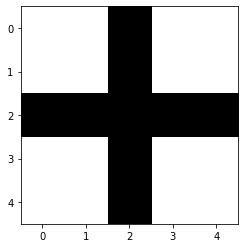

In [ ]:
plt.imshow(make_cross_image(), cmap="Greys");

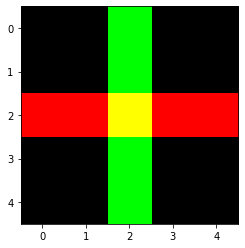

In [ ]:
plt.imshow(make_cross_image(False).permute(1,2,0));

In [ ]:
#export
def show_title(o, ax=None, ctx=None, label=None, **kwargs):
    "Set title of `ax` to `o`, or print `o` if `ax` is `None`"
    ax = ifnone(ax,ctx)
    if ax is None: print(o)
    elif hasattr(ax, 'set_title'): ax.set_title(o)
    elif isinstance(ax, pd.Series):
        while label in ax: label += '_'
        ax = ax.append(pd.Series({label: o}))
    return ax

In [ ]:
test_stdout(lambda: show_title("title"), "title")
# ensure that col names are unique when showing to a pandas series
assert show_title("title", ctx=pd.Series(dict(a=1)), label='a').equals(pd.Series(dict(a=1,a_='title')))

In [ ]:
#export
def show_image(im, ax=None, figsize=None, title=None, ctx=None, **kwargs):
    "Show a PIL or PyTorch image on `ax`."
    ax = ifnone(ax,ctx)
    if ax is None: _,ax = plt.subplots(figsize=figsize)
    # Handle pytorch axis order
    if isinstance(im,Tensor):
        im = to_cpu(im)
        if im.shape[0]<5: im=im.permute(1,2,0)
    elif not isinstance(im,np.ndarray): im=array(im)
    # Handle 1-channel images
    if im.shape[-1]==1: im=im[...,0]
    ax.imshow(im, **kwargs)
    if title is not None: ax.set_title(title)
    ax.axis('off')
    return ax

`show_image` can show b&w images...

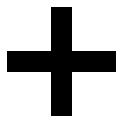

In [ ]:
im = make_cross_image()
ax = show_image(im, cmap="Greys", figsize=(2,2))

...and color images with standard `c*h*w` dim order...

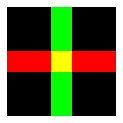

In [ ]:
im2 = make_cross_image(False)
ax = show_image(im2, figsize=(2,2))

...and color images with `h*w*c` dim order...

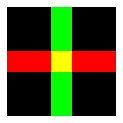

In [ ]:
im3 = im2.permute(1,2,0)
ax = show_image(im3, figsize=(2,2))

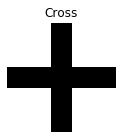

In [ ]:
ax = show_image(im, cmap="Greys", figsize=(2,2))
show_title("Cross", ax);

In [ ]:
#export
def show_titled_image(o, **kwargs):
    "Call `show_image` destructuring `o` to `(img,title)`"
    show_image(o[0], title=str(o[1]), **kwargs)

In [ ]:
#export
def show_image_batch(b, show=show_titled_image, items=9, cols=3, figsize=None, **kwargs):
    "Display batch `b` in a grid of size `items` with `cols` width"
    rows = (items+cols-1) // cols
    if figsize is None: figsize = (cols*3, rows*3)
    fig,axs = plt.subplots(rows, cols, figsize=figsize)
    for *o,ax in zip(*to_cpu(b), axs.flatten()): show(o, ax=ax, **kwargs)

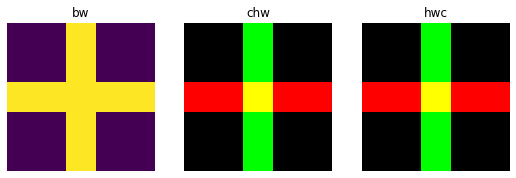

In [ ]:
show_image_batch(([im,im2,im3],['bw','chw','hwc']), items=3)

## Model init

In [ ]:
#export
def requires_grad(m):
    "Check if the first parameter of `m` requires grad or not"
    ps = list(m.parameters())
    return ps[0].requires_grad if len(ps)>0 else False

In [ ]:
tst = nn.Linear(4,5)
assert requires_grad(tst)
for p in tst.parameters(): p.requires_grad_(False)
assert not requires_grad(tst)

In [ ]:
#export
def init_default(m, func=nn.init.kaiming_normal_):
    "Initialize `m` weights with `func` and set `bias` to 0."
    if func:
        if hasattr(m, 'weight'): func(m.weight)
        if hasattr(m, 'bias') and hasattr(m.bias, 'data'): m.bias.data.fill_(0.)
    return m

In [ ]:
tst = nn.Linear(4,5)
tst.weight.data.uniform_(-1,1)
tst.bias.data.uniform_(-1,1)
tst = init_default(tst, func = lambda x: x.data.fill_(1.))
test_eq(tst.weight, torch.ones(5,4))
test_eq(tst.bias, torch.zeros(5))

In [ ]:
#export
def cond_init(m, func):
    "Apply `init_default` to `m` unless it's a batchnorm module"
    if (not isinstance(m, bn_types)) and requires_grad(m): init_default(m, func)

In [ ]:
tst = nn.Linear(4,5)
tst.weight.data.uniform_(-1,1)
tst.bias.data.uniform_(-1,1)
cond_init(tst, func = lambda x: x.data.fill_(1.))
test_eq(tst.weight, torch.ones(5,4))
test_eq(tst.bias, torch.zeros(5))

tst = nn.BatchNorm2d(5)
init = [tst.weight.clone(), tst.bias.clone()]
cond_init(tst, func = lambda x: x.data.fill_(1.))
test_eq(tst.weight, init[0])
test_eq(tst.bias, init[1])

In [ ]:
#export
def apply_leaf(m, f):
    "Apply `f` to children of `m`."
    c = m.children()
    if isinstance(m, nn.Module): f(m)
    for l in c: apply_leaf(l,f)

In [ ]:
tst = nn.Sequential(nn.Linear(4,5), nn.Sequential(nn.Linear(4,5), nn.Linear(4,5)))
apply_leaf(tst, partial(init_default, func=lambda x: x.data.fill_(1.)))
for l in [tst[0], *tst[1]]: test_eq(l.weight, torch.ones(5,4))
for l in [tst[0], *tst[1]]: test_eq(l.bias,   torch.zeros(5))

In [ ]:
#export
def apply_init(m, func=nn.init.kaiming_normal_):
    "Initialize all non-batchnorm layers of `m` with `func`."
    apply_leaf(m, partial(cond_init, func=func))

In [ ]:
tst = nn.Sequential(nn.Linear(4,5), nn.Sequential(nn.Linear(4,5), nn.BatchNorm1d(5)))
init = [tst[1][1].weight.clone(), tst[1][1].bias.clone()]
apply_init(tst, func=lambda x: x.data.fill_(1.))
for l in [tst[0], tst[1][0]]: test_eq(l.weight, torch.ones(5,4))
for l in [tst[0], tst[1][0]]: test_eq(l.bias,   torch.zeros(5))
test_eq(tst[1][1].weight, init[0])
test_eq(tst[1][1].bias,   init[1])

## Multiprocessing

In [ ]:
#export
from multiprocessing import Process, Queue

In [ ]:
#export 
class ProcessPoolExecutor(concurrent.futures.ProcessPoolExecutor):
    def __init__(self, max_workers=None, mp_context=None, initializer=None, initargs=(), on_exc=print):
        self.not_parallel = max_workers==0
        self.on_exc = on_exc
        if self.not_parallel: max_workers=1
        super().__init__(max_workers, mp_context, initializer=initializer, initargs=initializer)

    def map(self, f, items, *args, **kwargs):
        g = partial(f, *args, **kwargs)
        if self.not_parallel: return L(items).map(g)
        try: return super().map(g, items)
        except Exception as e: self.on_exc(e)

In [ ]:
#export 
def parallel(f, items, *args, n_workers=defaults.cpus, **kwargs):
    "Applies `func` in parallel to `items`, using `n_workers`"
    with ProcessPoolExecutor(n_workers) as ex:
        return L(progress_bar(ex.map(f,items, *args, **kwargs), total=len(items), leave=False))

In [ ]:
def add_one(x, a=1): 
    time.sleep(random.random()/100)
    return x+a

inp,exp = range(100),range(1,101)
test_eq(parallel(add_one, inp), exp)
test_eq(parallel(add_one, inp, n_workers=1), exp)
test_eq(parallel(add_one, inp, n_workers=0), exp)
test_eq(parallel(add_one, inp, n_workers=1, a=2), range(2,102))
test_eq(parallel(add_one, inp, n_workers=0, a=2), range(2,102))

In [ ]:
#export
def run_procs(f, f_done, args):
    "Call `f` for each item in `args` in parallel, yielding `f_done`"
    processes = L(args).map(Process, args=arg0, target=f)
    for o in processes: o.start()
    try: yield from f_done()
    except Exception as e: print(e)
    finally: processes.map(Self.join())

In [ ]:
#export 
def parallel_gen(cls, items, n_workers=defaults.cpus, as_gen=False, **kwargs):
    "Instantiate `cls` in `n_workers` procs & call each on a subset of `items` in parallel."
    batches = np.array_split(items, n_workers)
    idx = np.cumsum(0 + L(batches).map(len))
    queue = Queue()
    def f(batch, start_idx):
        for i,b in enumerate(cls(**kwargs)(batch)): queue.put((start_idx+i,b))
    def done(): return (queue.get() for _ in progress_bar(items, leave=False))
    yield from run_procs(f, done, L(batches,idx).zip())

In [ ]:
# old code from parallel_gen that Sylvain wants to keep (Oct-1)
    #res = []
    #for _ in progress_bar(items, leave=False):
    #    res.append(queue.get())
    #res = (queue.get() for _ in progress_bar(items, leave=False))
    #try: return res #if as_gen else [o[1] for o in sorted(res)]

`cls` is any class with `__call__`. It will be passed `args` and `kwargs` when initialized. Note that `n_workers` instances of `cls` are created, one in each process. `items` are then split in `n_workers` batches and one is sent to each `cls`. The function then returns a list of all the results, matching the order of `items` (if not `as_gen`) or a generator of tuples of item indices and results (if `as_gen`).

In [ ]:
class SleepyBatchFunc:
    def __init__(self): self.a=1
    def __call__(self, batch):
        for k in batch:
            time.sleep(random.random()/20)
            yield k+self.a

x = np.linspace(0,0.99,100)
res = L(parallel_gen(SleepyBatchFunc, x, n_workers=2))
test_eq(res.sorted().itemgot(1), x+1)

# Export -

In [ ]:
#hide
from local.notebook.export import notebook2script
notebook2script(all_fs=True)

Converted 00_test.ipynb.
Converted 01_core.ipynb.
Converted 01a_utils.ipynb.
Converted 01b_dispatch.ipynb.
Converted 01c_torch_core.ipynb.
Converted 02_script.ipynb.
Converted 03_dataloader.ipynb.
Converted 04_transform.ipynb.
Converted 05_data_core.ipynb.
Converted 06_data_transforms.ipynb.
Converted 07_vision_core.ipynb.
Converted 08_pets_tutorial.ipynb.
Converted 09_vision_augment.ipynb.
Converted 10_data_block.ipynb.
Converted 11_layers.ipynb.
Converted 11a_vision_models_xresnet.ipynb.
Converted 12_optimizer.ipynb.
Converted 13_learner.ipynb.
Converted 14_callback_schedule.ipynb.
Converted 14a_callback_data.ipynb.
Converted 15_callback_hook.ipynb.
Converted 16_callback_progress.ipynb.
Converted 17_callback_tracker.ipynb.
Converted 18_callback_fp16.ipynb.
Converted 19_callback_mixup.ipynb.
Converted 20_metrics.ipynb.
Converted 21_tutorial_imagenette.ipynb.
Converted 22_vision_learner.ipynb.
Converted 23_tutorial_transfer_learning.ipynb.
Converted 30_text_core.ipynb.
Converted 31_tex